In [ ]:
# To install planet terp api
!pip install planetterp
!pip install torch torchvision transformers datasets
# Evaluate
!pip install evaluate


In [ ]:
'''

Goal: Take a review of a particular professor & guess how many stars the review got

Step 1: Retrieving reviews using API

The 5 Professors excluding Max:
 The ideal candidates are ones that have over 100 reviews and are not all 5 or 1 stars
 1. Cylde Kruskal
 2. Nelson Padua-Perez
 3. Justin Wyss-Gallifent
 4. Jonathan Fernandes
 5. Mestiyage Gunatilleka

 Justin & Nelson need to be replaced as they overfill the datasets with 5's

'''


import planetterp, pandas as pd
from datasets import Dataset, DatasetDict

import torch

SEED = 2025

# Hugging



prof_names = ['Pedram Sadeghian',
              'Monique Koppel',
              'James Rainbolt',
              'Christiana Guest',
              'Clyde Kruskal',
              'Kendall Williams',
              'Jonathan Fernandes',
]
have_reviews = True


records = []
for prof in prof_names:
  info = planetterp.professor(name=prof, reviews='true') # returns dictionary -> list -> dictionary
  # Creates list with {prof, review, rating}
  for item in info['reviews']:
    # Removed formatting in prompt
    records.append({'professor' : prof, 'prompt' : " ".join(item['review'].split()), 'label' : item['rating']})

# converts dataframe to dataset
df = pd.DataFrame(records)
# Drops duplicates or NA
df = df.dropna()
df = df.drop_duplicates(subset=['prompt'])

# Converting labels from 1-5 to 0-4 to ensure it works with BERT
df['label'] = df['label'] - 1

# Convert df to dataset
dataset = Dataset.from_pandas(df)
# Takes 51 seconds with A100 GPU

In [ ]:
'''
Dataset Statistics Check
'''

print(df['label'].value_counts(), '\nPercentages:', round(df['label'].value_counts(normalize=True) * 100,2))
print(df['professor'].value_counts())

print(df.groupby('professor')['label'].value_counts().unstack(fill_value=0))


print(dataset)

label
0    231
4    227
3    167
2    132
1    128
Name: count, dtype: int64 
Percentages: label
0    26.10
4    25.65
3    18.87
2    14.92
1    14.46
Name: proportion, dtype: float64
professor
Jonathan Fernandes    178
Kendall Williams      134
Pedram Sadeghian      134
Christiana Guest      129
James Rainbolt        106
Monique Koppel        104
Clyde Kruskal         100
Name: count, dtype: int64
label                0   1   2   3   4
professor                             
Christiana Guest    62  25  15  11  16
Clyde Kruskal       28  16  24  17  15
James Rainbolt      48  11  12   9  26
Jonathan Fernandes  26  22  23  41  66
Kendall Williams    22  24  17  29  42
Monique Koppel      19  15  25  20  25
Pedram Sadeghian    26  15  16  40  37
Dataset({
    features: ['professor', 'prompt', 'label', '__index_level_0__'],
    num_rows: 885
})


In [ ]:
'''
Preprocessing
1. Tokenization
2. Truncating
3. Batching
'''

from transformers import DistilBertTokenizer, AutoTokenizer
from sklearn.model_selection import train_test_split

# Splitting dataset: We're splitting the database between (Training, Validation) and Testing (where we make predictions)
# Split dataset (30%: temp, 70%: train)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=2025)

# Split dataset (from: 50/50 -> 15%: validation, 15%: test)
valid_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=2025)

train_dataset =Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(valid_df)

# Combining into a Dataset Dict to follow example easier. Also removes professor and index_level columns
raw_dataset = DatasetDict({'train' : train_dataset.remove_columns(['professor', '__index_level_0__']),
                           'validation' : val_dataset.remove_columns(['professor', '__index_level_0__']),
                           'test' : test_dataset.remove_columns(['professor', '__index_level_0__'])})

print(raw_dataset)

# Load tokenizer
model_name = "distilbert-base-uncased"


tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocessing Function
def preprocess_function(examples):
  '''
  Basially, tokenizes and truncates the prompt and decreases the label by 1 so that it matches up with num_label
  '''
  return tokenizer(examples["prompt"], padding='max_length', truncation=True, max_length=128)

# Apply preprocessing
encoded_dataset = raw_dataset.map(preprocess_function, batched=True)


# Check processed data
print('Train:', encoded_dataset['train']['prompt'][0])



DatasetDict({
    train: Dataset({
        features: ['prompt', 'label'],
        num_rows: 619
    })
    validation: Dataset({
        features: ['prompt', 'label'],
        num_rows: 133
    })
    test: Dataset({
        features: ['prompt', 'label'],
        num_rows: 133
    })
})


Map:   0%|          | 0/619 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Train: While he was a very good lecturer and conveyed the material well, we were never fully prepared for the exams. We were given suggested problems in the textbook that would state clearly what equations we needed to use, and what specific process we needed to follow. Dr. Williams said the exams would be made directly based off these suggested problems, yet the exam questions were not clear or specific about what was being asked. The exam questions were often too long to complete within the allotted time, and many tutors I went to for help agreed. When I would approach him for help, he would simply tell me to do more practice problems, and disregarded me when I stated that the wording was confusing. He told me at one point that the homework questions would never appear on an exam as they were too hard and time consuming, then put a homework question almost word for word on an exam. In addition we were given the same exams as the honors sections, despite not signing up for the honors 

In [ ]:
'''
Model Configuration
1. Choose model: Doesn't need domain-specific knowledge

'''

from transformers import AutoModelForSequenceClassification



# Load DistilBERT model for classification
final_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
print(final_model.config)




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "dtype": "float32",
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.3",
  "vocab_size": 30522
}



In [ ]:
'''
Fine-Tuning
1. Training Arguments
2. Training the Model
3. Monitoring Training
'''


# 1
from transformers import TrainingArguments, DataCollatorWithPadding



training_args = TrainingArguments(
    output_dir="./results",           # Directory for saving model checkpoints
    eval_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",
    learning_rate=5e-05,              # Start with a small learning rate
    per_device_train_batch_size=16,  # Batch size per GPU
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.01,               # Regularization
    save_total_limit=2,              # Limit checkpoints to save space
    load_best_model_at_end=True,     # Automatically load the best checkpoint
    logging_dir="./logs",            # Directory for logs
    logging_steps=10,               # Log every 100 steps
    fp16=True                        # Enable mixed precision for faster training
)
# Increase num_train_epoch, decrease learning_rate
# 2
from transformers import Trainer

# Initialize DataCollatorWithPadding

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Custom Metric
from evaluate import load





trainer = Trainer(
    model=final_model,                          # The DistilBERT model
    args=training_args,                   # Training arguments
    train_dataset=encoded_dataset['train'],  # Training data
    eval_dataset=encoded_dataset['validation'],  # Validation data
    tokenizer=tokenizer,
    data_collator=data_collator
)




# Start training
trainer.train()





/tmp/ipython-input-2085119377.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.421500,1.248420
2,1.067400,1.126902
3,0.849100,1.122007


TrainOutput(global_step=117, training_loss=1.1493371572249975, metrics={'train_runtime': 9.2674, 'train_samples_per_second': 200.379, 'train_steps_per_second': 12.625, 'total_flos': 61501280014080.0, 'train_loss': 1.1493371572249975, 'epoch': 3.0})

{'eval_loss': 1.1220070123672485, 'eval_runtime': 0.1608, 'eval_samples_per_second': 827.241, 'eval_steps_per_second': 105.738, 'epoch': 3.0}


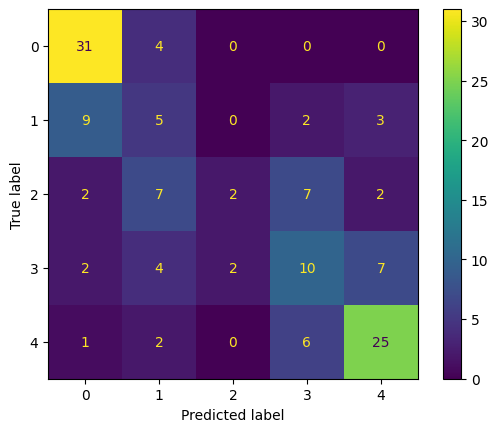

              precision    recall  f1-score   support

           0       0.69      0.89      0.78        35
           1       0.23      0.26      0.24        19
           2       0.50      0.10      0.17        20
           3       0.40      0.40      0.40        25
           4       0.68      0.74      0.70        34

    accuracy                           0.55       133
   macro avg       0.50      0.48      0.46       133
weighted avg       0.54      0.55      0.52       133

Example 0:
Text: This woman is literally a mystery. This class was a ridiculous amount of work for a one credit lab, but I gave her an additional star for her ginormous curve at the end of the semester.
True Label: 1, Predicted Label: 0
Example 1:
Text: OK these reviews are way too dramatic lmao. These kids get to college and learn the hard way you can't BS your way through like high school, then they blame the professor when they fail. Rainbolt is a really underrated professor. I had him for Orgo I. First

In [ ]:
'''
Evaluation

1. Model Evaluation
2. Error Analysis
'''

# 1

from sklearn.metrics import classification_report
import numpy as np

# Get predictions

results = trainer.evaluate()
print(results)


predictions = trainer.predict(encoded_dataset['test'])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = encoded_dataset['test']['label']

# Precision Recall Curve & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions
predictions = trainer.predict(encoded_dataset["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
#print(classification_report(encoded_dataset["test"]["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(encoded_dataset["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot()
plt.show()

# Generate classification report
print(classification_report(true_labels, predicted_labels))

# 2

# Inspect misclassified examples
for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)):
    if true != pred:
        print(f"Example {i}:")
        print(f"Text: {encoded_dataset['test']['prompt'][i]}")
        print(f"True Label: {true}, Predicted Label: {pred}")

That's all!